## 1. Load libraries

In [3]:
# Load libraries
import numpy as np
import pandas as pd
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# import plotly.offline as py
# py.init_notebook_mode(connected = True)
# import plotly.graph_objs as go
# import plotly.tools as tls

import warnings
warnings.filterwarnings("ignore")

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold

import xgboost as xgb

## 2. Load datasets

In [6]:
# Load the train and test datasets
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

# Sotre PassengerId of test dataset
PassengerId = test['PassengerId']

print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null 

## 3. Feature Engine

In [7]:
# full data
full = pd.concat([train, test], axis = 0)

# Length of the Name
full["Name_length"] = full["Name"].apply(len)

# Whether a passenger had a cabin on the boat
full["Has_Cabin"] = full["Cabin"].apply(lambda x: 0 if pd.isnull(x) else 1)

# FamilySize = SibSp + Parch
full["FamilySize"] = full["SibSp"] + full["Parch"] + 1

# IsAlone
full["IsAlone"] = full["FamilySize"].apply(lambda x: 1 if x == 1 else 0)


# Missing Value impute
full["Embarked"] = full["Embarked"].fillna("S")
full["Fare"] = full["Fare"].fillna(full["Fare"].median())

# Categorical Fare
# full["CategoricalFare"] = pd.qcut(full["Fare"], 4)

# impute Age
age_avg = full["Age"].mean()
age_std = full["Age"].std()
age_null_count = full["Age"].isnull().sum()
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size = age_null_count)
full["Age"][np.isnan(full["Age"])] = age_null_random_list
full["Age"] = full["Age"].astype(int)

# Categorical Age
# full["CategoricalAge"] = pd.cut(full["Age"], 5)

# Title from names
def get_title(name):
    title_search = re.search(" ([A-Za-z]+)\.", name)
    if title_search:
        return title_search.group(1)
    return ""
full["Title"] = full["Name"].apply(get_title)
full["Title"] = full["Title"].replace(["Lady", "Countess", "Capt", "Col", "Don", "Dr", "Major", "Rev", "Sir", "Jonkheer", "Dona"], "Rare")
full["Title"] = full["Title"].replace("Mlle", "Miss")
full["Title"] = full["Title"].replace("Ms", "Miss")
full["Title"] = full["Title"].replace("Mme", "Mrs")

# Mapping Sex
full["Sex"] = full["Sex"].map({"female": 0, "male": 1}).astype(int)

# Mapping titles
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
full["Title"] = full["Title"].map(title_mapping)
full["Title"] = full["Title"].fillna(0)

# Mapping Embarked
full["Embarked"] = full["Embarked"].map({"S": 0, "C": 1, "Q":2}).astype(int)

# Mapping Fare
full.loc[full["Fare"] <= 7.91, "Fare"] = 0
full.loc[(full["Fare"] > 7.91) & (full["Fare"] <= 14.454), "Fare"] = 1
full.loc[(full["Fare"] > 14.454) & (full["Fare"] <= 31), "Fare"] = 2
full.loc[full["Fare"] > 31, "Fare"] = 3
full["Fare"] = full["Fare"].astype(int)

# Mapping Age
full.loc[full["Age"] <= 16, "Age"] = 0
full.loc[(full["Age"] > 16) & (full["Age"] <= 32), "Age"] = 1
full.loc[(full["Age"] > 32) & (full["Age"] <= 48), "Age"] = 2
full.loc[(full["Age"] > 48) & (full["Age"] <= 64), "Age"] = 3
full.loc[full["Age"]  > 64, "Age"] = 4

full.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,1,NaN,0,0,"Braund, Mr. Owen Harris",0,1,3,1,1,0.0,A/5 21171,23,0,2,0,1
1,2,C85,1,3,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,1.0,PC 17599,51,1,2,0,3
2,1,NaN,0,1,"Heikkinen, Miss. Laina",0,3,3,0,0,1.0,STON/O2. 3101282,22,0,1,1,2
3,2,C123,0,3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,1.0,113803,44,1,2,0,3
4,2,NaN,0,1,"Allen, Mr. William Henry",0,5,3,1,0,0.0,373450,24,0,1,1,1


In [8]:
# Feature selection
drop_elements = ["Cabin", "Name", "PassengerId", "Ticket"]
full = full.drop(drop_elements, axis = 1)
train = full.loc[~np.isnan(full["Survived"]), ]
test = full.loc[np.isnan(full["Survived"]), ]
train.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,1,0,0,0,3,1,1,0.0,23,0,2,0,1
1,2,1,3,0,1,0,1,1.0,51,1,2,0,3
2,1,0,1,0,3,0,0,1.0,22,0,1,1,2
3,2,0,3,0,1,0,1,1.0,44,1,2,0,3
4,2,0,1,0,3,1,0,0.0,24,0,1,1,1


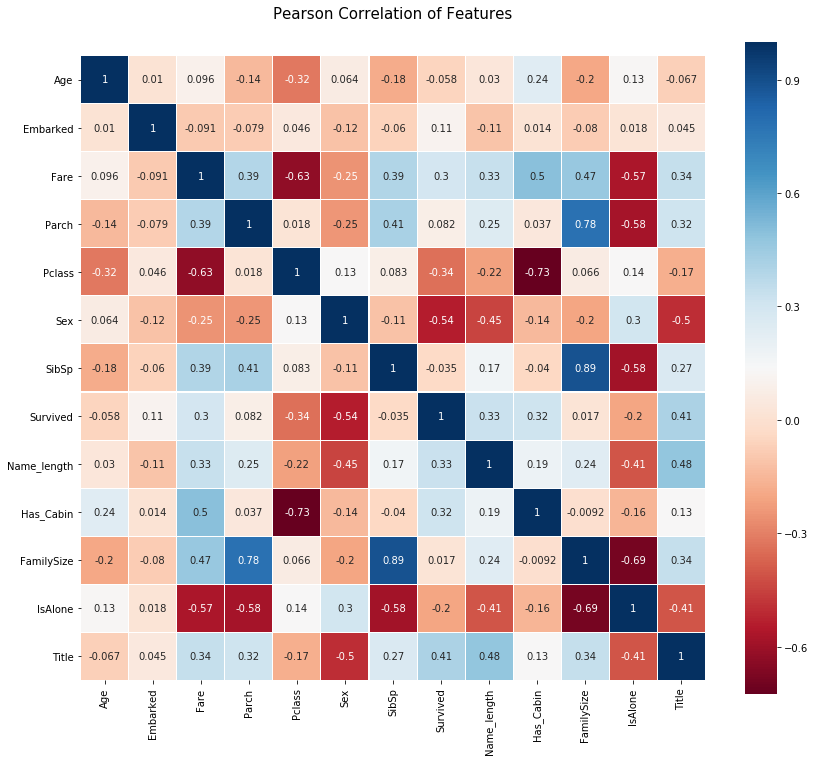

In [9]:
# Person Correlation Heatmap
colormap = plt.cm.RdBu
plt.figure(figsize = (14, 12))
plt.title("Pearson Correlation of Features", y = 1.05, size = 15)
sns.heatmap(train.astype(float).corr(), 
            linewidths = 0.1, 
            vmax = 1.0, 
            square = True, 
            cmap =  colormap, 
            linecolor = "white", 
            annot = True)

## 4. Emsembling & Stacking models

### 4.1 First Level Model

In [106]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(ntrain, n_folds = NFOLDS, random_state = SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed = 0, params = None):
        params["random_state"] = seed
        self.clf = clf(**params)
    
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        print(self.clf.fit(x, y).feature_importances_)

# Out-of-Fold Predictions
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain, ))
    oof_test = np.zeros((ntest, ))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
    
    oof_test[:] = oof_test_skf.mean(axis = 0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

# ****************************************************************
# Generating Base First-Level Model
# ****************************************************************
# 1 Random Forest
# 2 Extra Tree
# 3 AdaBoost
# 4 Gradient Boosting
# 5 Support Vector Machine

# ****************************************************************
# Parameters
# ****************************************************************
# n_jobs
# n_estimators
# max_depth
# verbose


# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'verbose': 0
}

# Extra Tree parameters
et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate': 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
    #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Machine parameters
svm_params = {
    'kernel': 'linear',
    'C': 0.025
}

# Create 5 objects that represent our 5 models
rf = SklearnHelper(clf = RandomForestClassifier, seed = SEED, params = rf_params)
et = SklearnHelper(clf = ExtraTreesClassifier, seed = SEED, params = et_params)
ada = SklearnHelper(clf = AdaBoostClassifier, seed = SEED, params = ada_params)
gb = SklearnHelper(clf = GradientBoostingClassifier, seed = SEED, params = gb_params)
svc = SklearnHelper(clf = svm.SVC, seed = SEED, params = svm_params)

In [107]:
# Create Numpy arrays of train, test and target dataframes to feed into models
y_train = train["Survived"].ravel()
train = train.drop(["Survived"], axis = 1)
test = test.drop(["Survived"], axis = 1)
x_train = train.values
x_test = test.values

# Output of the First level Predictions
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test)
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test)
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test)
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test)

[0.03647775 0.02262982 0.05038152 0.01775621 0.11293499 0.24437952
 0.10912823 0.05972127 0.07422741 0.01036538 0.2619979 ]
[0.03046117 0.02941635 0.05450431 0.01643817 0.12288866 0.3759116
 0.04840406 0.08517153 0.04451827 0.0207287  0.17155717]
[0.016 0.008 0.034 0.064 0.03  0.012 0.708 0.012 0.05  0.002 0.064]
[0.0944226  0.04489158 0.10125298 0.02990346 0.08312151 0.03768039
 0.39480434 0.02659263 0.07444424 0.0315647  0.08132156]


In [110]:
rf_features = rf.feature_importances(x_train, y_train)
et_features = et.feature_importances(x_train, y_train)
ada_features = ada.feature_importances(x_train, y_train)
gb_features = gb.feature_importances(x_train, y_train)

rf_features = [0.03143923, 0.02256151, 0.05081414, 0.01725614, 0.11309925, 0.24540255, 0.11146731, 0.0602838,  0.07370956, 0.01002953, 0.26393696]
et_features = [0.02857253, 0.02916473, 0.05472285, 0.01609138, 0.12346668, 0.37743706, 0.04909214, 0.08333648, 0.04608837, 0.02048121, 0.17154658]
ada_features = [0.012, 0.01, 0.04, 0.06, 0.032, 0.014, 0.7, 0.014, 0.052, 0.002, 0.064]
gb_features = [0.08006986, 0.08242734, 0.08902836, 0.02923033, 0.08409172, 0.03684323, 0.39558848, 0.01897393, 0.06785035, 0.02614564, 0.08975077]
cols = train.columns.values
feature_dataframe = pd.DataFrame({
    "features": cols,
    "Random Forest feature importances": rf_features,
    "Extra Tree feature importances": et_features,
    "AdaBoost feature importances": ada_features,
    "Gradient Boost feature importances": gb_features
})
# Create the new column containing the average of values
feature_dataframe["mean"] = feature_dataframe.mean(axis = 1)

feature_dataframe

,features,Random Forest feature importances,Extra Tree feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Age,0.031439,0.028573,0.012,0.080070,0.038020
1,Embarked,0.022562,0.029165,0.010,0.082427,0.036038
2,Fare,0.050814,0.054723,0.040,0.089028,0.058641
3,Parch,0.017256,0.016091,0.060,0.029230,0.030644
4,Pclass,0.113099,0.123467,0.032,0.084092,0.088164
5,Sex,0.245403,0.377437,0.014,0.036843,0.168421
6,Name_length,0.111467,0.049092,0.700,0.395588,0.314037
7,Has_Cabin,0.060284,0.083336,0.014,0.018974,0.044149
8,FamilySize,0.073710,0.046088,0.052,0.067850,0.059912
9,IsAlone,0.010030,0.020481,0.002,0.026146,0.014664


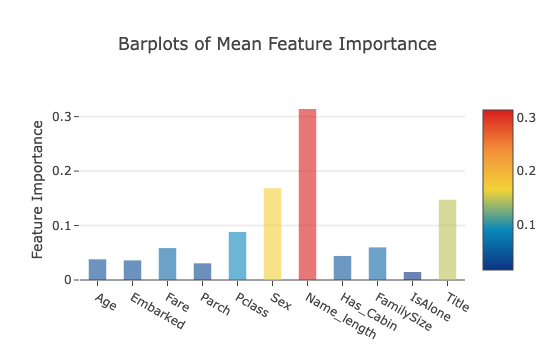

In [117]:
x = feature_dataframe["features"].values
y = feature_dataframe["mean"].values

data = [go.Bar(
    x = x, 
    y = y,
    width = 0.5,
    marker = dict(
        color = y,
        colorscale = "Portland",
        showscale = True,
        reversescale = False
    ),
    opacity = 0.6
)]

layout = go.Layout(
    autosize = True,
    title = "Barplots of Mean Feature Importance",
    hovermode = "closest",
    xaxis = dict(
        # title = "Pop",
        ticklen = 5,
        zeroline = False,
        # gridwidth = 2,
    ),
    yaxis = dict(
        title = "Feature Importance",
        ticklen = 5,
        gridwidth = 2,
    ),
    showlegend = False
)
fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = "bar-direct-labels")

### 4.2 Second level predictions from the first level output

In [118]:
# First level output as new features
base_predictions_train = pd.DataFrame({
    "RandomForest": rf_oof_train.ravel(),
    "ExtraTree": et_oof_train.ravel(),
    "AdaBoost": ada_oof_train.ravel(),
    "GradientBoost": gb_oof_train.ravel()
})
base_predictions_train

,RandomForest,ExtraTree,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0
7,0.0,1.0,0.0,1.0
8,1.0,0.0,1.0,1.0
9,1.0,1.0,1.0,1.0


In [120]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis = 1)
x_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis = 1)
x_train

array([[0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1.],
       ...,
       [0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [121]:
gbm = xgb.XGBClassifier(
    n_estimators = 2000,
    max_depth = 4,
    min_child_weight = 2,
    gamma = 0.9,
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = "binary:logistic",
    nthread = -1,
    scale_pos_weight = 1
).fit(x_train, y_train)
predictions = gbm.predict(x_test)

## 5 Submission file

In [123]:
StackingSubmission = pd.DataFrame({
    "PassengerId": PassengerId,
    "Survived": predictions
})
StackingSubmission.to_csv("./StackingSubmission.csv", index = False)